## Modelowanie układów przepływowych - ćwiczenia 
#### (budowa solwera równań płytkiej wody na bazie pakietu PyMPDATA)

In [20]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
   # !pip install PyMPDATA
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

### 0. potrzebne pakiety Pythona

In [21]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions

### 1. opis układu: symbole i równania

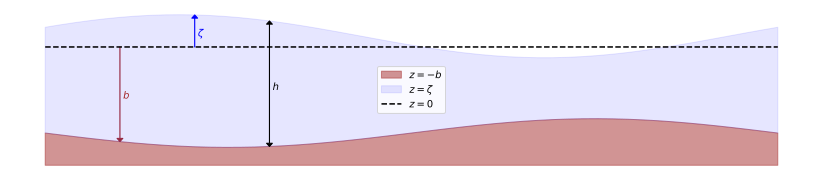

In [22]:
pyplot.figure(figsize=(14.5,3))
pyplot.axis('off')

x = np.linspace(-np.pi, np.pi)
z = np.cos(x+2)/2+.25
b = np.sin(x)/3-2

arrow_kwargs = {'length_includes_head': True, 'head_width': .05}

ix = 5; color='brown'; label='$b$'
pyplot.fill_between(x, b, -2.75, color=color, label=f'$z=-${label}', alpha=.5)
pyplot.arrow(x[ix], 0, 0, b[ix], color=color, **arrow_kwargs)
pyplot.annotate(f" {label}", xy=(x[ix], b[ix] + 1), color=color)

ix = 10; color='blue'; label=r'$\zeta$'
pyplot.fill_between(x, z, b, color=color, label=f'$z=${label}', alpha=.1)
pyplot.arrow(x[ix], 0, 0, z[ix], color=color, **arrow_kwargs)
pyplot.annotate(f" {label}", xy=(x[ix], z[ix] - .5), color=color)

ix = 15; color='black'; label='$h$'
pyplot.plot(x, np.full_like(x, 0), linestyle='--', color=color, label='$z=0$')
pyplot.arrow(x[ix], 0, 0, z[ix], color=color, **arrow_kwargs)
pyplot.arrow(x[ix], 0, 0, b[ix], color=color, **arrow_kwargs)
pyplot.annotate(f" {label}", xy=(x[ix], -1), color=color)

pyplot.legend(loc=10)
show_plot('symbols')

$$ \zeta(t; x,y) \rightarrow \text{wysokość swobodnej powierzchni względem geoidy (z=0)}$$
$$ b(x,y) \rightarrow \text{batymetria mierzona dodatnio w doół od geoidy}$$
$$ h(t; x,y) = \zeta + b \rightarrow \text{całkowita głębokość kolumny wody} $$
$$ \vec{u} = [u, v]$$
$$
\begin{cases}
  \partial_t h &=&\! -\nabla \cdot (\vec{u}h)\\
  \partial_t (hu) &=&\! -\nabla \cdot (\vec{u}hu) - gh\partial_x\zeta \\
  \partial_t (hv) &=&\! -\nabla \cdot (\vec{u}hv) - gh\partial_y\zeta
\end{cases}
$$

### 2. solwer "hello-world" zbudowany na bazie PyMPDATA

In [23]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray, bathymetry:np.ndarray, options: Options = None):
        self.bathymetry = bathymetry
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        X, Y, grid = 0, 1, h_initial.shape
        stepper = Stepper(options=options, grid=grid)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Constant(value=0)] * len(grid),
            'halo': options.n_halo,
        }
        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(np.zeros(grid), **kwargs),
            "vh": ScalarField(np.zeros(grid), **kwargs),
        }
        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()
    
    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h']-self.bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None) 
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[( 
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2 
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        assert np.amax(np.abs(courant_number)) <= 1

    def __call__(self, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1): 
            if it != 0:
                mask = self['h'] > eps
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output

### 3. Przykładowa symulacja

In [29]:
grid = (50, 40)
bathymetry = np.tile(np.linspace(0,1,grid[1]),(grid[0],1))

zeta=np.zeros(grid,dtype=float)
zeta[
    grid[0] // 2 - grid[0] // 20:
    grid[0] // 2 + grid[0] // 20,
    grid[1] // 2 - grid[1] // 20:
    grid[1] // 2 + grid[1] // 20
] += .025


h_initial = bathymetry + zeta

output = ShallowWaterEquationsIntegrator(
    h_initial=h_initial,
    bathymetry=bathymetry
)(
    nt=60, g=10, dt_over_dxy=(.25, .25), outfreq=(outfreq:=3)
)

### 4. Wizualizacja


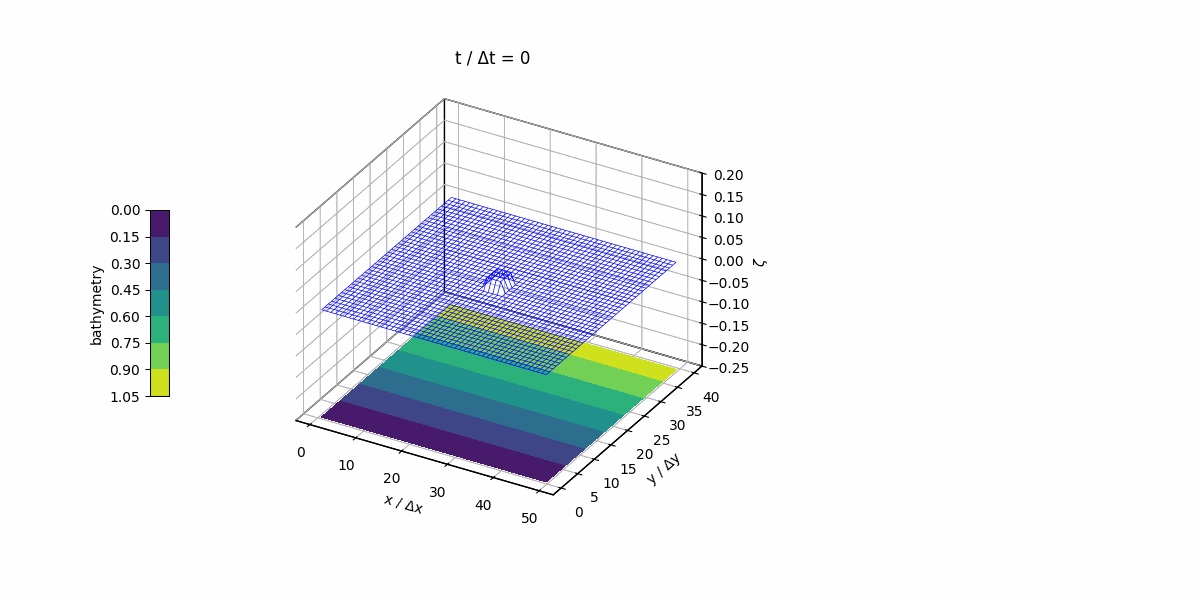

HTML(value="<a href='.\\tmp67ia75dk.gif' target='_blank'>.\\tmp67ia75dk.gif</a><br>")

In [32]:
def plot(frame, *, zlim=(-.25, 0.2)):
    psi = output['h'][frame]
    xi, yi = np.indices(psi.shape)
    fig, ax = pyplot.subplots(subplot_kw={"projection": "3d"}, figsize=(12, 6))
    ax.plot_wireframe(xi+.5, yi+.5, psi-bathymetry, color='blue', linewidth=.5)
    ax.set(zlim=zlim, proj_type='ortho', title=f"t / Δt = {frame*outfreq}", zlabel=r"$\zeta$")
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.pane.fill = False
        axis.pane.set_edgecolor('black')
        axis.pane.set_alpha(1)
    for axis in ('x', 'y'):
        getattr(ax, f'set_{axis}label')(f"{axis} / Δ{axis}")
    pyplot.colorbar(
        ax.contourf(xi+.5, yi+.5, bathymetry, zdir='z', offset=zlim[0]),
        pad=.1, aspect=10, fraction=.02, label='bathymetry', location='left'
    ).ax.invert_yaxis()
    return fig
show_anim(plot, range(len(output['h'])))

## Projekt zaliczeniowy 

#### sprawozdanie: obliczenia, wizualizacje i kompilacja pdf na GitHub Actions (pdf jako artefakt, maksimum 3 strony tekstu, w tym maksimum połowa to rysunki)

- fizyka/numeryka:
  - określ i opisz układ i parametry symulacji (warunek początkowy, batymetria, siatka, parametry fizyczne)
  - zdefiniuj pytanie, na które szukasz odpowiedzi (np. zależność wysokości fali przy brzegu od ...)
  - sprawdź i udokumentuj analizę zależności wyników od podwojenia rozdzielczości czasowej i przestrzennej
- wizualizacja:
  - pole (wektorowe) prędkości
  - powierzchnia płynu (zarówno 2D, jak i przekroje)
  - wyłącznie grafika wektorowa

#### Sposób wysłania
- w ciągu tygodnia: zgłoszenie przez UPEL pytania, na które będziemy poszukiwać odpowiedzi
- w ciągu dwóch tygodni: wrzucenie przez UPEL odnośnika do "runu" generującego artefakt ze sprawozdaniem (/actions/runs/...), który pozwala oceniającym jednoznacznie zlokalizować kod oraz logi wykonania symulacji.

#### Sposób oceny
- 25% fizyka (opis modelu, opis układu i parametrów)
- 25% numeryka (opis siatki, analiza zbieżności)
- 25% technikalia (odtwarzalność, jakość wykresów i poprawność opisów osi, czytelność kodu)
- 10% + 15% postawienie pytania i interpretacja wyników